# Lab 7 - Convolutional Neural Networks

### Eric Smith and Jake Carlson

## Introduction
In this lab, we will develop a multi-layer perceptron to perform classification on the CIFAR-10 data set. Similar to Lab 3, we will subset the data set to images of trucks and automobiles. The original data set has 60,000 images. 50,000 of these are training images and 10,000 are test images. The images are 32x32 pixels and contain objects from 10 classes. The classes are listed below.
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

This data set was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton for their paper <i>Learning Multiple Layers of Features from Tiny Images</i>. In this study, the authors use several filters to train their model to learn interesting regularities in the set of images, rather than focus on correlations between nearby pixels [1].

For this lab, we will use the images of automobile, trucks, and birds. The trucks, in this case, are semi-trucks. We have been guaranteed by the people who generated the data set that these three classes are mutually exclusive. The automobile class will have images of sedans and SUVs. The truck class will have big trucks only. Neither class has images of pickup trucks.

## Business Understanding

### Motivations
The law treats cars and trucks differently on the road. Trucks often have to stop at weigh stations so their contents can be verified. It would be useful to have a tool that can distinguish between cars and trucks. Once a truck has been identified, a record of the truck and its location can be made so that Customs or local authorities can make sure the truck is checked at the next weigh station.

The classification system developed could be deployed in conjunction with CCTV cameras on the highway. This would give authorities real time metrics on how many trucks are passing through an area. If a truck passes by two cameras, our model could incorporate the location of each camera and the time between sightings. This would reduce the necessity of having police officers on the road to monitor the speed of semi-trucks.

If a truck is identified as speeding, a police officer could be dispatched to monitor the vehicle. Using a distributed network of cameras on the highway would mean officers could spend more time patrolling residential and commerical areas. The average annual income for a Texas state trooper is \$60,612 [2]. Positioning a trooper on the highway costs roughly \$31 an hour. Meanwhile, the cost of running a CCTV camera 24/7 is approximately 54 cents per month [3].

If a trooper is positioned on the highway, people alter their behaviors because they recognize that they are being monitored. If a criminal organization is transporting illicit substances, they can have a lead car drive ahead of the transport truck so officers can be located before the truck passes through an area. However, people often don't recognize when they are being monitored by CCTV camera.

### Objectives
Our main objective is to accurately pick out a semi-truck from a sea of automobiles. A state trooper can accurately distinguish between a semi-truck and an automobile 100% of the time. But troopers rotate in and out of an area, leaving gaps in the amount of time a road is being monitored. Take the following simplified case: one trooper is assigned to watch a highway for one business day where they start at 8am, end at 5pm, and take an hour for lunch. A second trooper rotates in to monitor the highway starting at 6pm and ending at 3am. The percentage of time the road is covered is given by
<br><br>
$$t_{officer} = \frac{24 - ((6-5) + 1 + (6-3))}{24}\times100 = 79.2\%$$


<br><br>
So 79% is our threshold to beat. In order for our algorithm to be useful to authorities, it must minimize the number of trucks that slip through undetected. We will do this by measuring the performance of our model with Recall such that
<br><br>

$$Recall = \frac{TP}{TP + FN}$$
<br>
Where TP is the true positive rate, and FN is the false negative rate.

Therefore, our objective is to minimize the number of false negatives produced and reach 79% recall to be a viable replacement for police officers.

## Data Preparation

### Data Cleaning
We will start by loading the images and subsetting to 1000 images. We will use a ratio of cars to trucks that most closely matches real-world driving conditions. A project at The George Washington University [2] puts the percentage of highway vehicles that are trucks anywhere between 5% and 25% depeding on the stretch of road. We will use 25% because it balances the classes somewhat while still conforming to a real-world estimate of the ratio between trucks and cars. We will reduce the dimensionality of our images by transforming them to gray scale. This will reduce the number of features for each image from 3,072 to 1,024. We also scale the pixel values to be between -0.5 and 0.5.

In [1]:
import numpy as np
import pandas as pd

df_labels = pd.read_csv('../Lab3/data/labels.csv')
df_labels = df_labels[ df_labels.label.isin(['automobile', 'truck']) ]
df_labels = pd.concat([df_labels[df_labels.label == "truck"].sample(n=250),
                      df_labels[df_labels.label == "automobile"].sample(n=750)])

df_labels.head()

,id,label
3719,3720,truck
22623,22624,truck
2215,2216,truck
35737,35738,truck
46651,46652,truck


In [4]:
from PIL import Image

# reads a png and returns a list of all pixel values in order r, g, b
def get_img_as_rgb_row(image_path):
    img = Image.open(image_path)
    if len(img.split()) == 4:
        # remove alpha if present
        r, g, b, a = img.split()
        img = Image.merge("RGB", (r, g, b))
    r, g, b = img.split()
    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    # convert to gray scale
    img_list = [(r[i] * 0.2989 + g[i] * 0.5870 + b[i] * 0.1140)/255 - 0.5 for i in range(len(r))]
    return img_list

# generate column names
cols = ['label']
for i in range(1024):
    cols.append("{}".format(i))

# create df and extract color values for all car and truck images
df = pd.DataFrame(columns=cols, index=range(len(df_labels.id.tolist())))
data_dir = "../Lab3/data/cifar-10/"
idx = 0
for r in df_labels.iterrows():
    entry = [r[1].label]
    entry.extend(get_img_as_rgb_row("{}{}.png".format(data_dir, r[1].id)))
    df.loc[idx] = entry
    idx += 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1025 entries, label to 1023
dtypes: object(1025)
memory usage: 7.8+ MB


In [5]:
df.head()

,label,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,truck,-0.0686204,-0.0734357,-0.0729886,-0.0729886,-0.0729886,-0.0738827,-0.075502,-0.0794231,-0.0851992,...,0.0393165,0.0330933,0.025698,0.0319212,0.0462647,0.0573455,0.0451349,0.0347792,0.0657016,0.0774651
1,truck,0.4999,0.492058,0.495979,0.495979,0.495979,0.495979,0.495979,0.495979,0.495979,...,-0.148157,-0.125609,-0.113398,-0.087678,-0.0672204,-0.0468894,-0.0104267,0.00525804,0.0170216,0.0366275
2,truck,0.158691,0.082189,-0.0215498,-0.155909,-0.274583,-0.306846,-0.283186,-0.265749,-0.27779,...,-0.122975,-0.121609,-0.128878,-0.134763,-0.132908,-0.133355,-0.157462,-0.191714,-0.221084,-0.243294
3,truck,0.394704,0.386862,0.386862,0.380639,0.386862,0.403507,0.415102,0.412969,0.413416,...,-0.0465867,-0.036122,-0.0330949,-0.0326478,-0.0169631,-0.0169631,-0.0208843,-0.0248055,-0.0248055,-0.0263824
4,truck,-0.35491,-0.384727,-0.449218,-0.440113,-0.414284,-0.392165,-0.394805,-0.319208,-0.243467,...,0.0173549,-0.00964627,-0.0064502,0.0119835,0.0708012,0.06688,0.0186537,-0.0369678,-0.0879431,-0.0761796


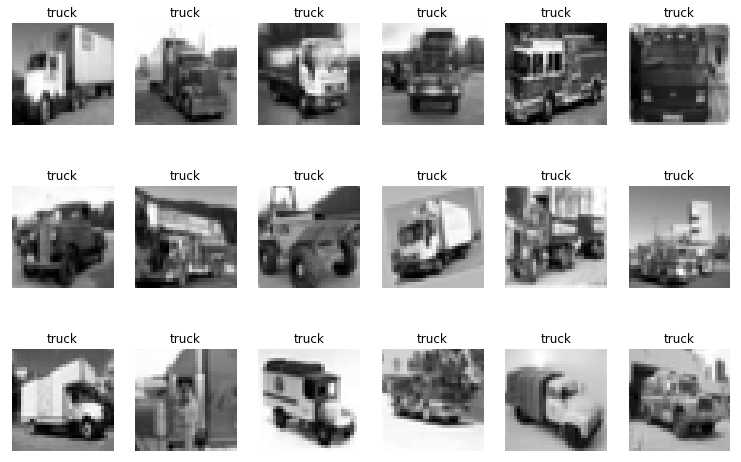

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(df.drop(['label'], axis=1).astype(np.float).values, df['label'].values, 32, 32)

In [7]:
label_dict = {
    'truck': 1,
    'automobile': 0
}
df['label_int'] = [label_dict[x] for x in df.label]
df.head()

,label,0,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label_int
0,truck,-0.0686204,-0.0734357,-0.0729886,-0.0729886,-0.0729886,-0.0738827,-0.075502,-0.0794231,-0.0851992,...,0.0330933,0.025698,0.0319212,0.0462647,0.0573455,0.0451349,0.0347792,0.0657016,0.0774651,1
1,truck,0.4999,0.492058,0.495979,0.495979,0.495979,0.495979,0.495979,0.495979,0.495979,...,-0.125609,-0.113398,-0.087678,-0.0672204,-0.0468894,-0.0104267,0.00525804,0.0170216,0.0366275,1
2,truck,0.158691,0.082189,-0.0215498,-0.155909,-0.274583,-0.306846,-0.283186,-0.265749,-0.27779,...,-0.121609,-0.128878,-0.134763,-0.132908,-0.133355,-0.157462,-0.191714,-0.221084,-0.243294,1
3,truck,0.394704,0.386862,0.386862,0.380639,0.386862,0.403507,0.415102,0.412969,0.413416,...,-0.036122,-0.0330949,-0.0326478,-0.0169631,-0.0169631,-0.0208843,-0.0248055,-0.0248055,-0.0263824,1
4,truck,-0.35491,-0.384727,-0.449218,-0.440113,-0.414284,-0.392165,-0.394805,-0.319208,-0.243467,...,-0.00964627,-0.0064502,0.0119835,0.0708012,0.06688,0.0186537,-0.0369678,-0.0879431,-0.0761796,1


In [8]:
df.to_csv('./clean-data/vehicles.csv')

### Train Test Split
We will pull out 10% of our samples to serve as a test set for our classifier. This will allow us to gauge the generalization performance of our different models given their different architectures. We will train each model on the training set that contains 90% of our samples. Because of the large training time, we will only train and test once for each architecture.

In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv('./clean-data/vehicles.csv', index_col=0)

X = df.drop(['label', 'label_int'], axis=1).astype(np.float)
y = df['label_int'].astype(np.int)

print(X.shape)
print(y.shape)

(1000, 1024)
(1000,)


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical

NUM_CLASSES = 2

col_names = X.columns.values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=64)
for train_idx, test_idx in sss.split(X.values, y.values):
    # X_train - 80% training attribute set
    # X_test - 20% test attribute set
    # y_train - 80% training labels
    # y_test - 20% training labels
    X_train, X_test = pd.DataFrame(X.values[train_idx], columns=col_names), pd.DataFrame(X.values[test_idx], columns=col_names)
    y_train, y_test = pd.DataFrame(y.values[train_idx], columns=["label_int"]), pd.DataFrame(y.values[test_idx], columns=["label_int"])

y_train, y_test = y_train.values.flatten(), y_test.values.flatten()

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

Using TensorFlow backend.


## Modeling
We will look at two different convolutional network architectures and see which one performs the best on our test set accorging to recall. We will then compare the best network to a simple multi-layer perceptron.

### First Network Architecture

In [38]:
%%time

import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

class_weight = {
    1: 4,
    0: 1
}

cnn = Sequential()
cnn.add(Reshape((1,32,32), input_shape=(1,1024)))

num_filters_layers = [32,64]
for num_filters in num_filters_layers:    
    cnn.add(Conv2D(filters=num_filters, kernel_size= (3, 3), padding='same', input_shape=(1,32,32)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

cnn.add(Flatten())
cnn.add(Dense(100))
cnn.add(Activation('relu'))
# cnn.add(Dense(24))
# cnn.add(Activation('relu'))
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe,
        class_weight=class_weight,
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 59.7 s, sys: 7.07 s, total: 1min 6s
Wall time: 34 s


In [39]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.recall_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.recall_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

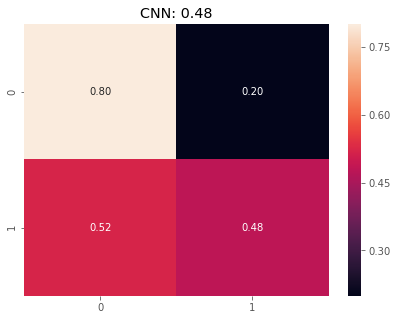

In [40]:
compare_mlp_cnn(cnn, None, X_test, y_test)

## References
Alex Krizhevsky, 2009: <a href="http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf">Learning Multiple Layers of Features from Tiny Images</a>

Face the Facts USA, 2013: <a href="https://www.facethefactsusa.org/facts/get-numbers-truck">Get the numbers of that truck</a>